# Zixi Jiang Final Project: What is trending now in women's clothes?
### An analysis for equity investors who care about trending apparels and for fashionista who want to invest.


In [432]:
#setting up environment and installing required packages
import google
from google.cloud import vision
import os,io
import requests
from bs4 import BeautifulSoup
import pandas as pd
#import scrape_farfetch as far
#import scrape_hm as hm
#import api_weekly as api
import argparse
import numpy as np
import scipy as sp
import locale
import matplotlib.pyplot as plt
from PIL import Image

#!pip install plotly
import plotly 
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
#!pip install chart_studio
import chart_studio.plotly as py
import plotly.graph_objs as go
import datetime
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Use my credential needed to access Google Vision API
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=r'data/Token.json'
client=vision.ImageAnnotatorClient()

Scenario: An investor would love to invest in some equities. Since she is interested in fashion industry, she narrowed the choice down to four tickers: HNNMY(H&M), IDEXY(ZARA), LVMUY(LVMH),PPRUF(Kering). She might be more willing to buy stuff from and learn about the trend of the entity of which she holds the equity. 
Among these, H&M and Zara stand for fast fashion, affordable brands. 
LVMH and Kering, on the other hands, are well-known for their luxurious goods. 

Let's first help the investor to compare and contrast these companies' stock market performance. 

In [227]:
#I requested the Alphavantage API to get the adjusted weekly close price for these four stocks, and these csv files 
#have been pre-processed in the python scripts. 
LVMH=pd.read_csv("data/LVMUY_stock.csv",index_col=0)
Kering=pd.read_csv("data/PPRUF_stock.csv",index_col=0)
HM=pd.read_csv("data/HNNMY_stock.csv",index_col=0)
ZARA=pd.read_csv("data/IDEXY_stock.csv",index_col=0)
LVMH.rename(index=pd.to_datetime)
Kering.rename(index=pd.to_datetime)
HM.rename(index=pd.to_datetime)
ZARA.rename(index=pd.to_datetime)
ZARA.head(5)
ZARA.name='ZARA-IDEXY'
HM.name='H&M-HNNMY'
LVMH.name='LVMH-LVMUY'
Kering.name='Kering-PPRUF'

Let's see the interactive time-series stock price graphs of the four companies within available time range. The investor can choose candlestick graph or the graph with 'Close','High',and 'Low'. 

In [228]:
#Here I define a function to draw interactive plot of WEEKLY stock price of each company, using plotly.iplot. The graph can
#show both candlestick graph and line graph of the stock price. I defined the data and the layout in fig, and customized
#it a little bit. cadetblue #87CEFA
def trace_plot(df):
    trace = go.Candlestick(x=df.index,
                       open=df.Open,
                       high=df.High,
                       low=df.Low,
                       close=df.Close,
                       name = 'Candlestick')
    trace_close = go.Scatter(x=list(df.index),
                         y=list(df.Close),
                         name='Close',line=dict(color='#71adf5'))
    trace_high = go.Scatter(x=list(df.index),
                        y=list(df.High),
                        visible = False,
                        name='High',
                        line=dict(color='#f2c270'))
    trace_low = go.Scatter(x=list(df.index),
                       y=list(df.Low),
                       visible = False,
                       name='Low',
                       line=dict(color='#f28170'))
    
    data=[trace,trace_close,trace_high,trace_low]
    updatemenus = list([
        dict(type="buttons",
            active=99,
             x = 0.05,
             y = 0.99,
             bgcolor = '#a7bdde',
             bordercolor = '#FFFFFF',
             font = dict( color='#7d8ca3', size=11 ),
             direction = 'left',
             xanchor = 'left',
             yanchor = 'top',
             buttons=list([
                 dict(label = 'Candlestick',
                     method = 'update',
                     args = [{'visible': [True, False, False, False]},
                             {'title': f'Candlestick of this ticker {df.name}'}]),
                 dict(label = 'Close-High-Low',
                     method = 'update',
                     args = [{'visible': [False, True, True, True]},
                             {'title': f'Close, High,and Low price of this ticker {df.name}'}
                            ])
             ]))])
     # define the data and layout, and store them in the fig dictionary                        
    layout=go.Layout(title=f"Stock market performance of {df.name}",autosize=True,updatemenus=updatemenus,
                     plot_bgcolor = '#ffe5e8')
    #I had to use offline.iplot in order to show this graph in notebook
    fig=dict(data=data,layout=layout)
    return plotly.offline.iplot(fig)


## ZARA
Stock price dropped sharply in 2014. The mean stock price over the past years are 17.51 dollars. 

In [229]:
trace_plot(ZARA)
ZARA.Close.describe()

count    619.000000
mean      17.519810
std        5.420444
min        6.000000
25%       14.420000
50%       16.466000
75%       18.245000
max       32.740000
Name: Close, dtype: float64

## H&M
Stock price has been rising in March 2020. The average stock price is 4.2 dollars. 

In [230]:
trace_plot(HM)  
HM.Close.describe()

count    254.000000
mean       4.219837
std        1.237765
min        2.095000
25%        3.171250
50%        3.843000
75%        5.260000
max        7.460000
Name: Close, dtype: float64

## LVMH
The stock price has been rising from 2009, and the max price is 119.8 dollars. 

In [231]:
trace_plot(LVMH)
LVMH.Close.describe()

count    700.000000
mean      42.473008
std       21.429526
min        9.300000
25%       31.347500
50%       35.210000
75%       51.967500
max      119.800000
Name: Close, dtype: float64

## Kering
The stock price rised significantly during 2016 to 2018, and has been rising with rather big flunctuation. Max price is 740.72 dollars. 

In [232]:
trace_plot(Kering)
Kering.Close.describe()

count    694.000000
mean     263.827491
std      167.949168
min       45.500000
25%      150.000000
50%      190.241250
75%      360.737500
max      740.720000
Name: Close, dtype: float64

### Now that we've seen the equity market, the consumer would love to see the fundamental aspect of financial analysis, how are these company running and what are they selling. 

#### Thus, we might want to take a look at what high-end and fast-fashion companies sell online. 

## H&M

For this part, I am using weekly updated women's apparels items on H&M websites

In [ ]:
#read the csv file stored through my python script, and manually categorize the items
hm=pd.read_csv("data/H&M_product.csv")
descriptions=hm['description']
cat_lis=[]
for i in descriptions:
    cat_lis.append(i.split()[-1])
hm['category']=cat_lis
for i in range(len(hm['price'])):
    hm['price'][i]=float(locale.atof(hm['price'][i].strip("$")))
    
#add one more variable called keywords which are the descriptive words for the item
kw_lis=[]
for i in descriptions:
    kw_lis.append(i.split()[0:-1])
hm['keywords']=kw_lis

The hm product table looks like this. This is a table of details of this week's just-arrived items at H&M official website. We can look at what are the latest trends through analyzing the products. 

In [467]:
hm.head(5)

description  price  articlecode  category  \
0               Tulle Dress    349    918109001     Dress   
1  Jacquard-patterned Shirt     99    935192001     Shirt   
2       Lyocell-blend Dress    149    918126002     Dress   
3    Jacquard-patterned Top    149    944484001       Top   
4            Short Necklace  34.99    908245001  Necklace   

                    color brand              keywords  
0                     NaN   H&M               [Tulle]  
1                     NaN   H&M  [Jacquard-patterned]  
2  Powder beige/patterned   H&M       [Lyocell-blend]  
3  Powder beige/patterned   H&M  [Jacquard-patterned]  
4  Powder beige/patterned   H&M               [Short]

Text(0.5, 1.0, 'The price distribution of H&M new arrival items')

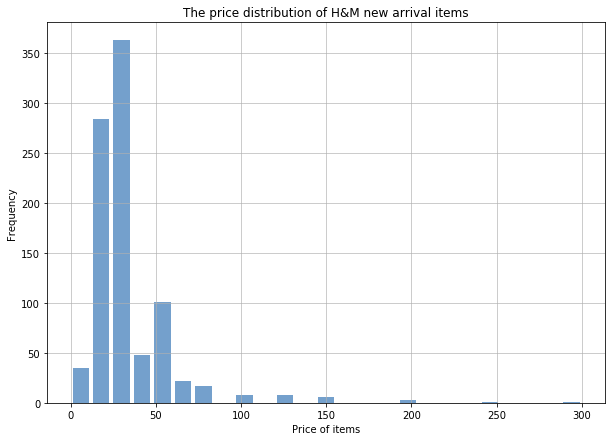

In [301]:
price=hm['price']
#neglecting items that are over 300 since they are outliers
price.plot.hist(figsize=(10,7),bins=25,color='#6596c7',alpha=0.9,rwidth=0.8,range=(0,300))
plt.grid(alpha=0.8)
plt.xlabel('Price of items')
plt.title('The price distribution of H&M new arrival items')


Text(0.5, 1.0, 'The price distribution of H&M new arrival items')

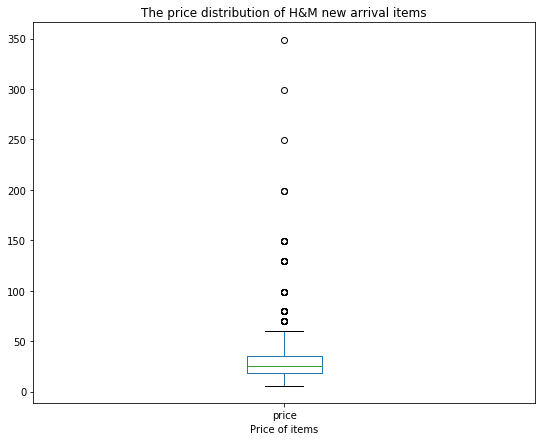

In [289]:
price.plot.box(figsize=(9,7))
plt.xlabel('Price of items')
plt.title('The price distribution of H&M new arrival items')

In [326]:
data=hm[['price','category']]
layout=go.Layout(title='Interactive H&M products by their category, hover to see the price',autosize=True,
                     )
fig=go.Figure(data=[go.Bar(x=hm['category'],y=hm['price'])],layout=layout)
plotly.offline.iplot(fig)


Text(0, 0.5, 'Frequency of appearance')

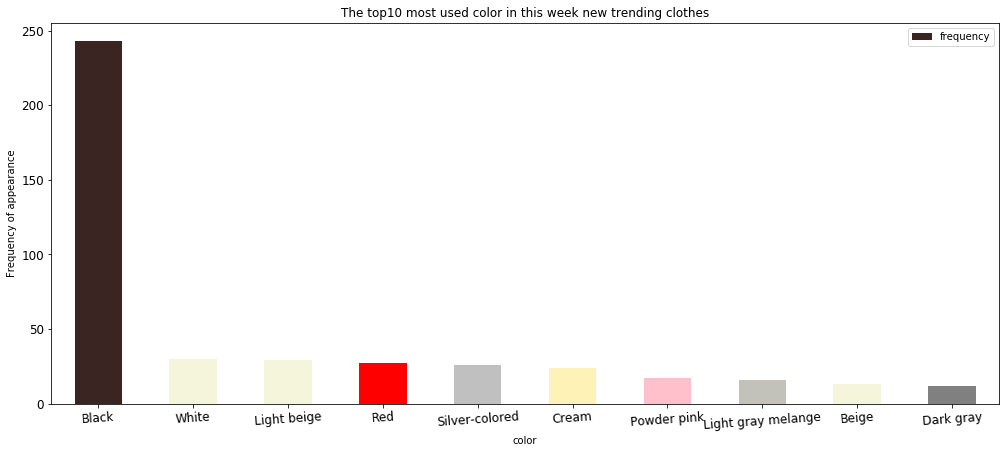

In [398]:
#color
color_lis=[]
color_dict={}
for color in hm['color']:
    color_dict[color]=color_dict.get(color,0)+1
    color_lis = list(color_dict.items())
color_scheme=pd.DataFrame.from_records(color_lis,columns=['color','frequency'])

TOP10=color_scheme.sort_values(by='frequency',ascending=False).head(10)
TOP10.plot(kind='bar',x='color',y='frequency',color=['#3b2523','beige','beige','red','silver','#fff2b7'
                                                    ,'pink','#c2c1ba','beige','gray'
                                                    ],figsize=(17,7),legend=True,
           rot=4,fontsize=12)
plt.title("The top10 most used color in this week new trending clothes")
plt.ylabel("Frequency of appearance")

The most used color in this batch of new arrivals are as above. 

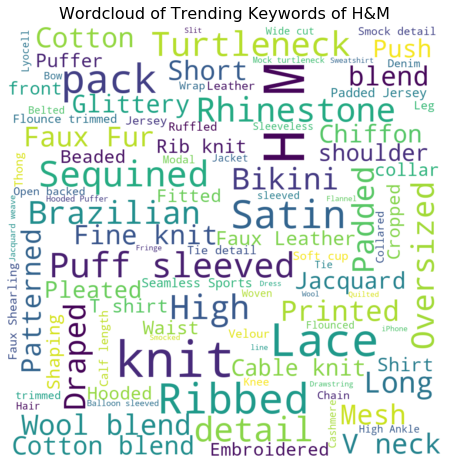

In [474]:
kw_lis=[]
for word in hm['keywords']:
    kw_lis=kw_lis+word
unique_string=(" ").join(kw_lis)
wordcloud = WordCloud(max_font_size=130,max_words=100,background_color='white',
                      width = 1000, height = 1000).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.savefig("hm_wordcloud"+".png", bbox_inches='tight')
plt.title("Wordcloud of Trending Keywords of H&M",fontsize=16)
plt.show()
plt.close()

We can find a little pattern in the keyword wordcloud. The most mentioned trend are 'knit','puff','Turtleneck',etc.
It is not hard to imagine these might be the descriptions for seasonal items such as incoming sweaters. 

## Desinger Brand (Farfetch)

To represent designers' brand goods, I am using Farfetch, a luxury fashion retail platform. I scrapped their weekly updated new arrival in women's apparels. The table has the description of the items, the designers, links of the item image, price, and the category of each good. 

In [411]:
#add one more variable called category which is the last word of the description
far=pd.read_csv("data/farfetch_product.csv")
descriptions=far['description']
cat_lis=[]
for i in descriptions:
    cat_lis.append(i.split()[-1])
far['category']=cat_lis

#add one more variable called keywords which are the descriptive words for the item
kw_lis=[]
for i in descriptions:
    kw_lis.append(i.split()[0:-1])
far['keywords']=kw_lis


In [412]:
far.head(5)

description          brand  \
0              floral lace cropped top        Miu Miu   
1    1969 nano metal-disc shoulder bag   Paco Rabanne   
2               Razi satin midi skirt        Nanushka   
3  chain-link appliqué slingback pumps  Saint Laurent   
4       feather trim blazer mini dress     The Attico   

                                                 img currency  price category  \
0  https://cdn-images.farfetch-contents.com/16/15...      USD   1050      top   
1  https://cdn-images.farfetch-contents.com/15/72...      USD    760      bag   
2  https://cdn-images.farfetch-contents.com/15/69...      USD    445    skirt   
3  https://cdn-images.farfetch-contents.com/15/43...      USD    875    pumps   
4  https://cdn-images.farfetch-contents.com/15/67...      USD   2344    dress   

                             keywords  
0             [floral, lace, cropped]  
1  [1969, nano, metal-disc, shoulder]  
2                 [Razi, satin, midi]  
3   [chain-link, appliqué, slingback]  
4       [feather, trim, blazer, mini]

Text(0.5, 1.0, 'The price distribution of Farfetch new arrival items')

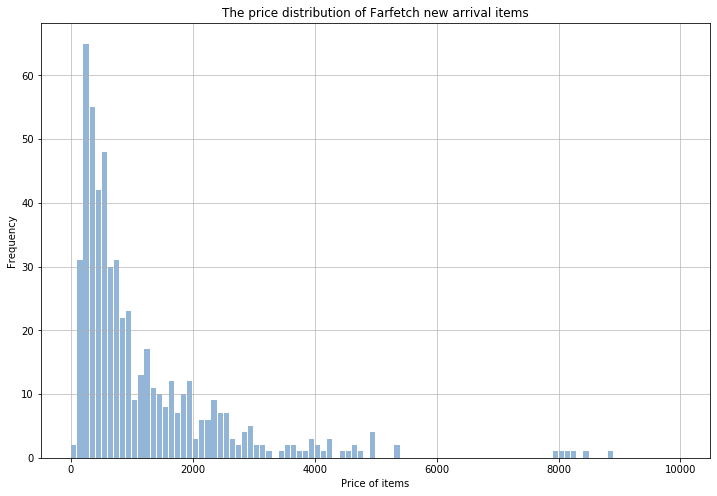

In [304]:
price=far['price']
#items that are beyond 10000 are neglected here 
price.plot.hist(figsize=(12,8),bins=100,color='#6596c7',alpha=0.7,rwidth=0.85,range=(0,10000))
plt.grid(alpha=0.8)
plt.xlabel('Price of items')
plt.title('The price distribution of Farfetch new arrival items')


Overall price is really high. 

Text(0.5, 1.0, 'The price distribution of Farfetch new arrival items')

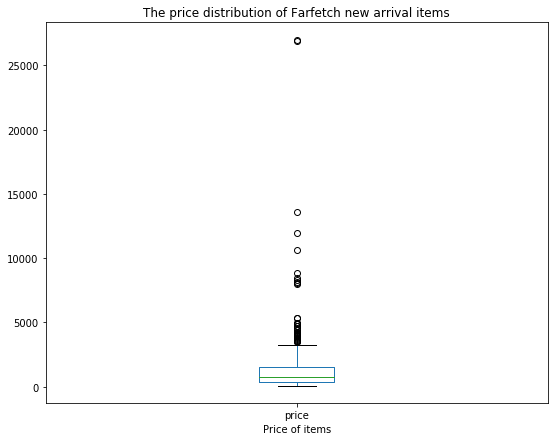

In [306]:
price.plot.box(figsize=(9,7))
plt.xlabel('Price of items')
plt.title('The price distribution of Farfetch new arrival items')

In [404]:
data=far[['price','category']]
layout=go.Layout(title='Interactive Farfetch products by their category, hover to see the price',autosize=True,
                     plot_bgcolor = '#e1ecf0')
fig=go.Figure(data=[go.Bar(x=far['category'],y=far['price'])],layout=layout)
plotly.offline.iplot(fig)

Text(0, 0.5, 'Frequency of their appearance')

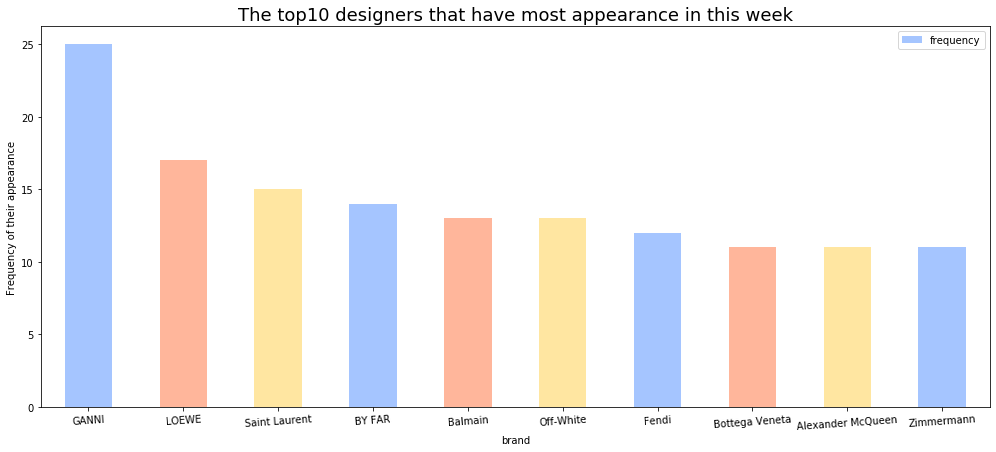

In [480]:
brand_lis=[]
brand_dict={}
for brand in far['brand']:
    brand_dict[brand]=brand_dict.get(brand,0)+1
    brand_lis = list(brand_dict.items())
brand=pd.DataFrame.from_records(brand_lis,columns=['brand','frequency'])

TOP10=brand.sort_values(by='frequency',ascending=False).head(10)
TOP10.plot(kind='bar',x='brand',y='frequency',color=['#a5c5ff','#ffb69b','#ffe6a1'],figsize=(17,7),legend=True,
           rot=4,fontsize=10)
plt.title("The top10 designers that have most appearance in this week",fontsize=18)
plt.ylabel("Frequency of their appearance")

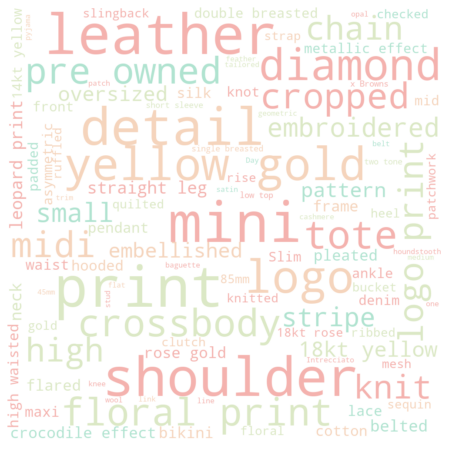

In [478]:
kw_lis=[]
for word in far['keywords']:
    kw_lis=kw_lis+word
unique_string=(" ").join(kw_lis)

#define a color function to change wordcloud color
def multi_color_func(word=None, font_size=None,
                     position=None, orientation=None,
                     font_path=None, random_state=None):
    colors = [[4, 77, 82],
              [25, 74, 85],
              [82, 43, 84],
              [158, 48, 79]]
    rand = random_state.randint(0, len(colors) - 1)
    return "hsl({}, {}%, {}%)".format(colors[rand][0], colors[rand][1], colors[rand][2])

#create the wordcloud for the keywords
wordcloud = WordCloud(max_font_size=130,max_words=100,background_color='white',
                      width = 1000, height = 1000,color_func=multi_color_func).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.savefig("farfetch_wordcloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

We can find a little pattern in the keyword wordcloud. The most mentioned trend are 'shoulder','leather','detail',etc. 

## Extension of Farfetch product analysis

#### I found the product images on the Farfetch websites are scrapable, therefore I stored the links of these images in the csv files. I tried to use Google Vision API to detect labels in these images to find potential pattern or trend. Since the image analysis requests would take a long time to run , I have collected the labels that are detected in these images and stored them in another csv. 

This is the Google Vision API I used to detect image labels. As an example, one request is made in the following cell to detect a product image. 

In [481]:
inner_label_lis=list()
def detect_labels_uri(uri):
    """Detects labels in the file located in Google Cloud Storage or on the
    Web."""
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()
    image = vision.Image()
    image.source.image_uri = uri
    inner_label_lis=list()
    response = client.label_detection(image=image)
    labels = response.label_annotations
    #print('Labels:')

    for label in labels:
        #print(label.description)
        inner_label_lis.append(label.description)
    return inner_label_lis

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
detect_labels_uri("https://cdn-images.farfetch-contents.com/16/09/69/94/16096994_30430564_300.jpg")

['Brown',
 'Product',
 'Sleeve',
 'Textile',
 'Pattern',
 'Orange',
 'White',
 'Peach',
 'Fashion',
 'Neck']

The file contains all the labels detected in hundreds of farfetch product images, and the frequency of these labels' appearance.

Text(0, 0.5, 'Frequency of their appearance')

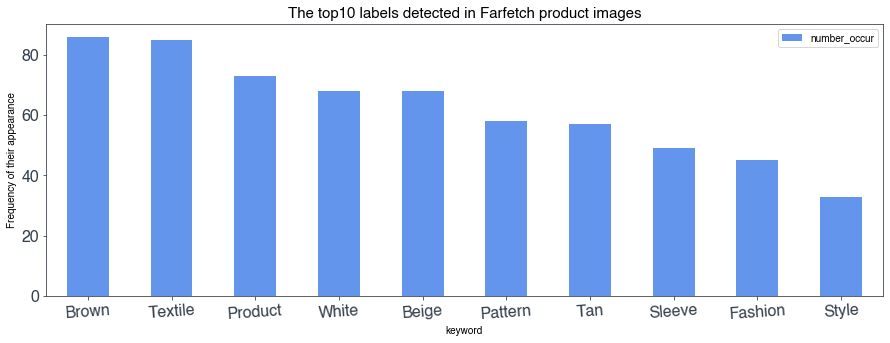

In [500]:
# This is a file that I scraped and stored using python script
image_labels=pd.read_csv("data/
                         image_keywords.csv")
#make the bar plots
top10=image_labels.sort_values(by='number_occur',ascending=False).head(10)
top10.plot(kind='bar',x='keyword',y='number_occur',color='cornflowerblue',figsize=(15,5),legend=True,
           rot=4,fontsize=16)
plt.title("The top10 labels detected in Farfetch product images",fontsize=15)
plt.ylabel("Frequency of their appearance")


5.What did you set out to study?  (i.e. what was the point of your project?  This should be close to your Milestone 1 assignment, but if you switched gears or changed things, note it here.)
In my initial proposal, I would love to study the fashion history and the how it relates to the financial market. However, I found out that major magazines that have historic archives of their issues cover images are protected by copyright. Therefore, I could not scrape their images as a time-series data to compare with financial ticker performances. Then, I turn to study the fashion industry companies' equity performance and their newly-arrived clothes on their websites. This could help find some trends and patterns. If the time is long enough, I could scrape the product weekly to create time-series database to compare with stock price. 


6.What did you Discover/what were your conclusions (i.e. what were your findings?  Wereyour original assumptions confirmed, etc.?)
I found that the clothes are related to the season, and the keywords of the current trend could be extracted by analyzing the iamges and descriptions of products. This could help me make shopping decision or outfit ideas by looking at what label or color is trending right now. I thought about this idea because normally people who own a compnay's equity mgiht be more willing to buy that company's stuff. Therefore, this analysis might be of use somehow.


7.What difficulties did you have in completing the project?

A lot of websites I intended to scrape have some kind of prohibitted content or hidden content. This makes it harder for me to collect information. 


8.What skills did you wish you had while you were doing the project?
I set up the Google Vision API for image analysisi, and I'm quite proud of what it can do. 

9.What would you do “next” to expand or augment the project?
I could keep collecting weekly data, or scrape more product from retail platforms such as ZARA, which is not included in this analysis but could be very helpful. Or I can scrape social media for text analysis of what they think is trending right now. 
